In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Configuración del directorio
if Path.cwd().name == "notebooks":
    os.chdir("..")
print("Directorio de trabajo actual:", Path.cwd())

# Carga de datos
DATA_PATH = Path("data/processed_logs/logs_normalizados.csv")
TARGET = "action"
TIME_COL = "timestamp"

df = pd.read_csv(DATA_PATH, parse_dates=[TIME_COL], low_memory=False)

print("="*50)
print("CARGA DE DATOS COMPLETADA")
print("="*50)
print(f"Dimensiones del dataset: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

Directorio de trabajo actual: /Users/alonso/Downloads/Tesis_SIEM_ML
CARGA DE DATOS COMPLETADA
Dimensiones del dataset: (845316, 13)
Columnas: ['timestamp', 'src_ip', 'dst_ip', 'protocol', 'action', 'description', 'event_id', 'severity', 'src_user', 'object_type', 'object_name', 'log_source', 'fuente']


In [3]:
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Número de registros: {df.shape[0]}")
print(f"Número de variables: {df.shape[1]}")

# Primero verificar una muestra de los datos
print("\nMuestra de fechas:")
print(df[TIME_COL].head())

# Intentar diferentes formatos
try:
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], format='%b %d, %Y @ %H:%M:%S.%f')
    print(" Conversión exitosa con formato específico")
except:
    try:
        # Intentar con inferencia automática
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True)
        print(" Conversión exitosa con inferencia automática")
    except:
        # Último intento con coerce para evitar errores
        df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors='coerce')
        print("Conversión con coerción - verificar valores nulos")

# Verificar resultados
nulos = df[TIME_COL].isnull().sum()
if nulos > 0:
    print(f" Advertencia: {nulos} registros no pudieron convertirse a fecha")

print(f"Período temporal: {df[TIME_COL].min()} a {df[TIME_COL].max()}")
print(f"Duración: {(df[TIME_COL].max() - df[TIME_COL].min()).days} días")

print("\n=== TIPOS DE DATOS ===")
print(df.dtypes.value_counts())

=== INFORMACIÓN GENERAL DEL DATASET ===
Número de registros: 845316
Número de variables: 13

Muestra de fechas:
0   2025-05-10 15:47:04.800
1   2025-05-10 15:47:04.800
2   2025-05-10 15:47:04.798
3   2025-05-10 15:47:04.797
4   2025-05-10 15:47:04.796
Name: timestamp, dtype: datetime64[ns]
 Conversión exitosa con formato específico
Período temporal: 2024-02-09 08:56:38 a 2025-05-10 15:47:04.800000
Duración: 456 días

=== TIPOS DE DATOS ===
object            12
datetime64[ns]     1
Name: count, dtype: int64


In [4]:
print("=== ANÁLISIS DE VALORES NULOS ===")
missing_analysis = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

missing_df = pd.DataFrame({
    'Valores_Nulos': missing_analysis,
    'Porcentaje_Nulos': missing_percentage
})

# Mostrar solo columnas con valores nulos
print(missing_df[missing_df['Valores_Nulos'] > 0])

print(f"\n=== ANÁLISIS DE DUPLICADOS ===")
duplicate_count = df.duplicated().sum()
duplicate_percentage = (duplicate_count / len(df)) * 100
print(f"Registros duplicados: {duplicate_count:,} ({duplicate_percentage:.2f}%)")

# Identificar columnas con alto porcentaje de nulos
high_missing_cols = missing_percentage[missing_percentage > 50]
print(f"\nColumnas con más del 50% de valores nulos: {len(high_missing_cols)}")

=== ANÁLISIS DE VALORES NULOS ===
             Valores_Nulos  Porcentaje_Nulos
dst_ip              796466         94.221096
protocol            790884         93.560751
severity            249850         29.556994
src_ip              206582         24.438435
event_id            201000         23.778090
src_user             54432          6.439249
object_name          48852          5.779141
object_type          48850          5.778904

=== ANÁLISIS DE DUPLICADOS ===
Registros duplicados: 127,581 (15.09%)

Columnas con más del 50% de valores nulos: 2


=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (ACTION) ===
                                                    Frecuencia  Porcentaje
action                                                                    
-                                                       547312   64.746438
object-operation-performed                               74670    8.833383
scheduled-task-updated                                   37210    4.401904
post                                                     30320    3.586824
credential-manager-credentials-were-read                 22545    2.667050
...                                                        ...         ...
El estado del dispositivo '10251-002907514' ha ...           1    0.000118
El estado del dispositivo '10191-326030095' ha ...           1    0.000118
El estado del dispositivo '11150-00370119' ha c...           1    0.000118
El estado del dispositivo '11150-093600015' ha ...           1    0.000118
El estado del dispositivo '10443-101605282' ha

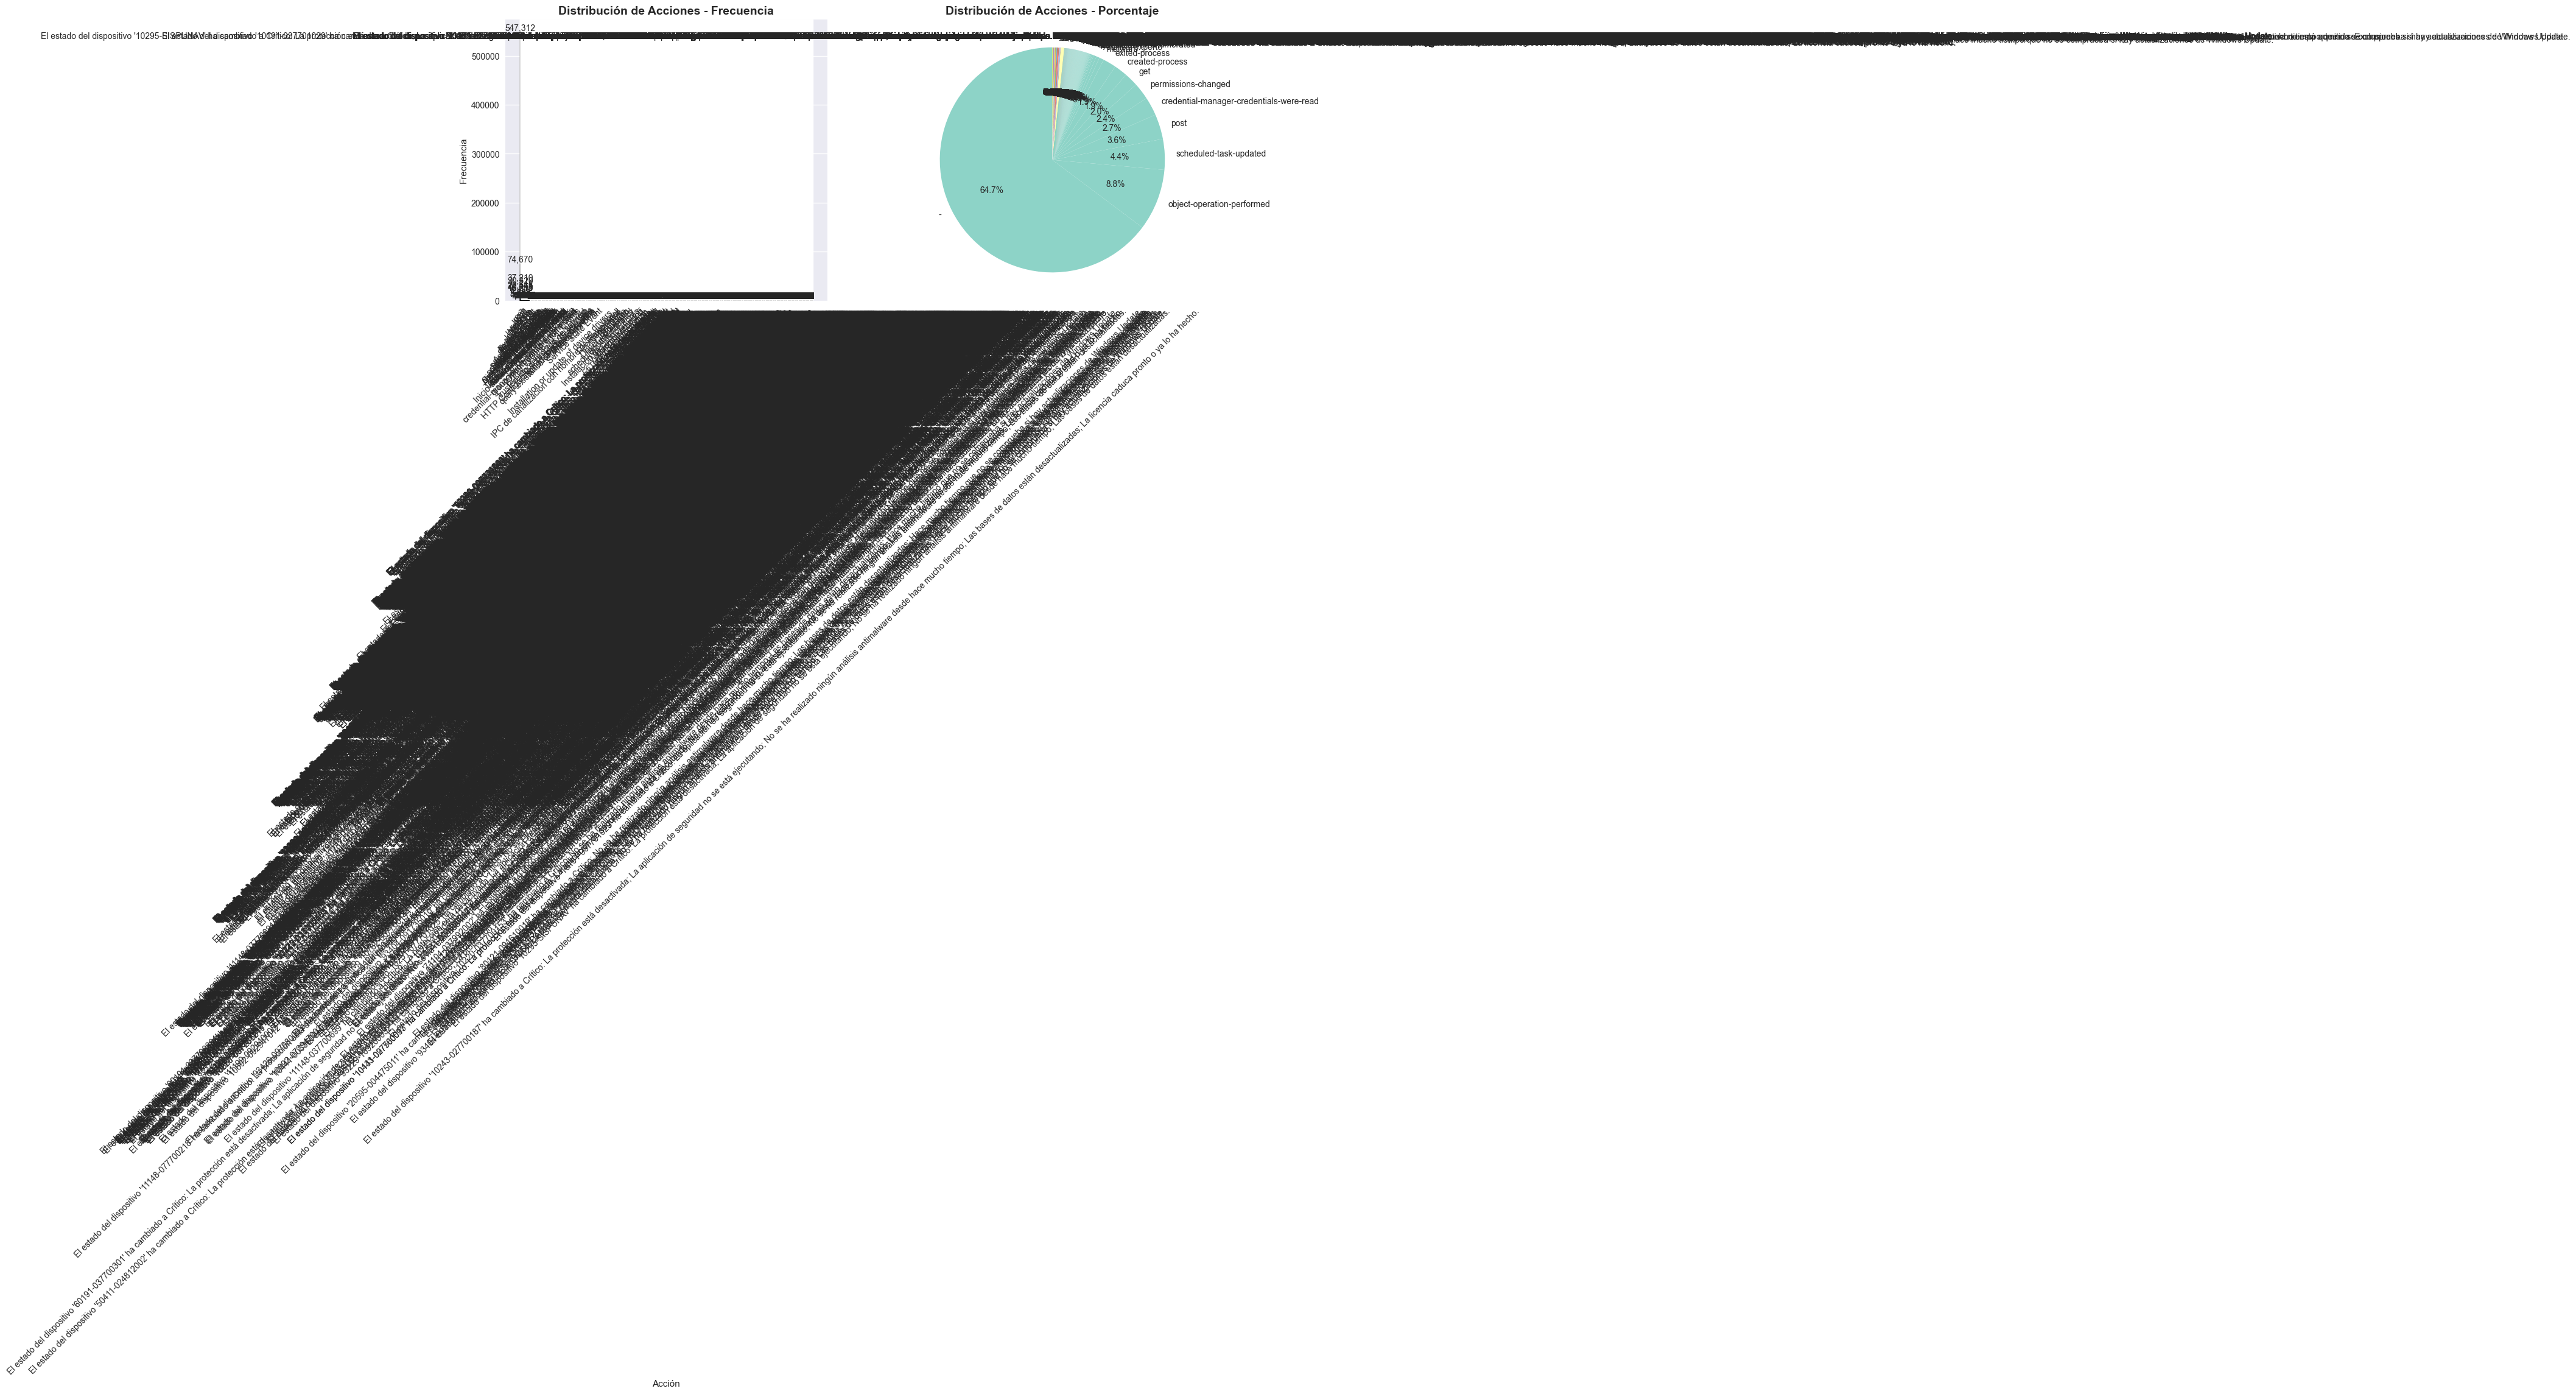

In [5]:
print("=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (ACTION) ===")
action_distribution = df[TARGET].value_counts()
action_percentage = df[TARGET].value_counts(normalize=True) * 100

action_summary = pd.DataFrame({
    'Frecuencia': action_distribution,
    'Porcentaje': action_percentage
})
print(action_summary)

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
bars = ax1.bar(action_distribution.index, action_distribution.values, 
               color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Distribución de Acciones - Frecuencia', fontsize=14, fontweight='bold')
ax1.set_xlabel('Acción')
ax1.set_ylabel('Frecuencia')
ax1.tick_params(axis='x', rotation=45)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
             f'{height:,}', ha='center', va='bottom')

# Gráfico de pie
colors = plt.cm.Set3(np.linspace(0, 1, len(action_percentage)))
wedges, texts, autotexts = ax2.pie(action_percentage.values, 
                                  labels=action_percentage.index, 
                                  autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('Distribución de Acciones - Porcentaje', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

=== ANÁLISIS DE DISTRIBUCIÓN TEMPORAL ===


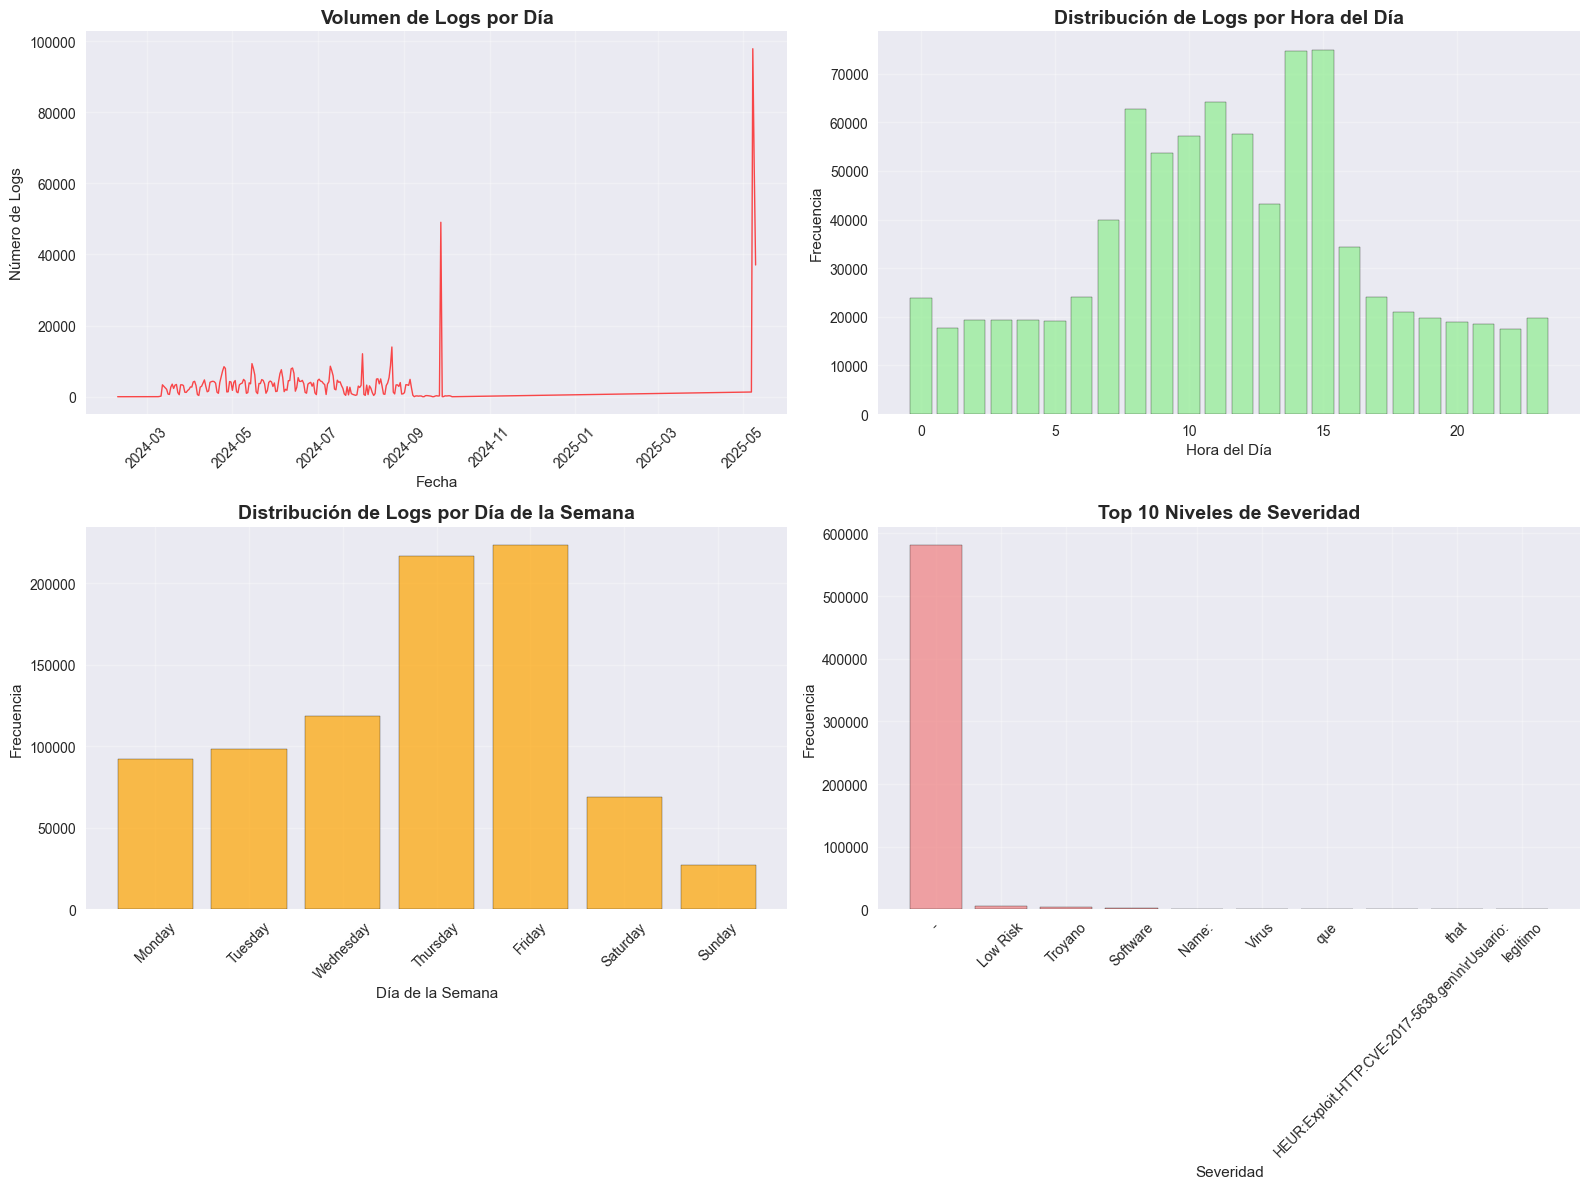

• Hora pico de logs: 15:00 hrs (74,960 logs)
• Día de la semana con más logs: Friday
• Promedio diario de logs: 3644


In [6]:
# Preparar datos temporales
df['fecha'] = df[TIME_COL].dt.date
df['hora'] = df[TIME_COL].dt.hour
df['dia_semana'] = df[TIME_COL].dt.day_name()
df['mes'] = df[TIME_COL].dt.month

print("=== ANÁLISIS DE DISTRIBUCIÓN TEMPORAL ===")

# Visualizaciones temporales
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Logs por día
logs_por_dia = df.groupby('fecha').size()
ax1.plot(logs_por_dia.index, logs_por_dia.values, color='red', alpha=0.7, linewidth=1)
ax1.set_title('Volumen de Logs por Día', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Número de Logs')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Logs por hora del día
hora_dist = df['hora'].value_counts().sort_index()
ax2.bar(hora_dist.index, hora_dist.values, color='lightgreen', edgecolor='black', alpha=0.7)
ax2.set_title('Distribución de Logs por Hora del Día', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hora del Día')
ax2.set_ylabel('Frecuencia')
ax2.grid(True, alpha=0.3)

# 3. Logs por día de la semana
dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dia_semana_dist = df['dia_semana'].value_counts().reindex(dias_orden)
ax3.bar(dia_semana_dist.index, dia_semana_dist.values, color='orange', edgecolor='black', alpha=0.7)
ax3.set_title('Distribución de Logs por Día de la Semana', fontsize=14, fontweight='bold')
ax3.set_xlabel('Día de la Semana')
ax3.set_ylabel('Frecuencia')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Distribución de severidad (si existe)
if 'severity' in df.columns:
    severity_counts = df['severity'].value_counts().head(10)
    ax4.bar(severity_counts.index, severity_counts.values, color='lightcoral', edgecolor='black', alpha=0.7)
    ax4.set_title('Top 10 Niveles de Severidad', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Severidad')
    ax4.set_ylabel('Frecuencia')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas temporales
print(f"• Hora pico de logs: {hora_dist.idxmax()}:00 hrs ({hora_dist.max():,} logs)")
print(f"• Día de la semana con más logs: {dia_semana_dist.idxmax()}")
print(f"• Promedio diario de logs: {logs_por_dia.mean():.0f}")

=== ANÁLISIS DE DIRECCIONES IP Y PROTOCOLOS ===
                         Metrica  Valor
0   Direcciones IP origen únicas   3078
1  Direcciones IP destino únicas     17
2              Protocolos únicos      5


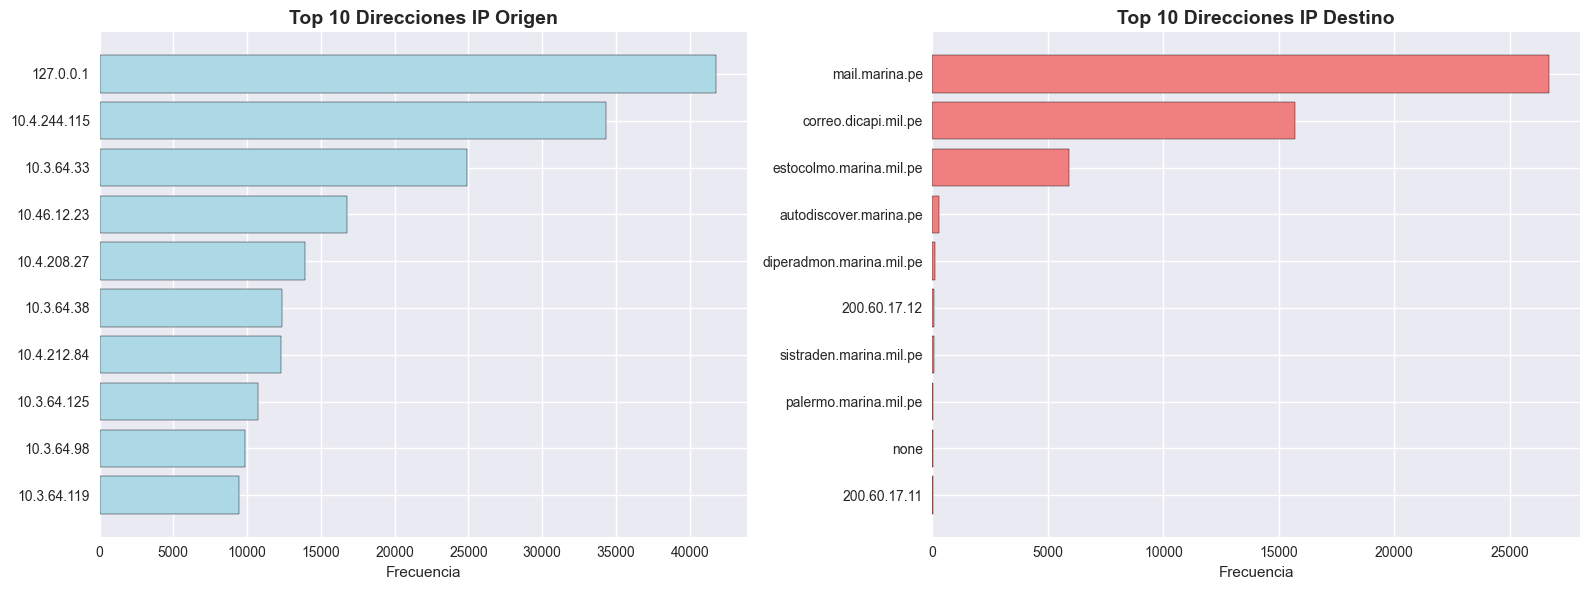


Top 10 Protocolos:
protocol
https/tls1.2    48838
HTTP/2           5576
http               12
HTTP                5
HTTPS               1
Name: count, dtype: int64


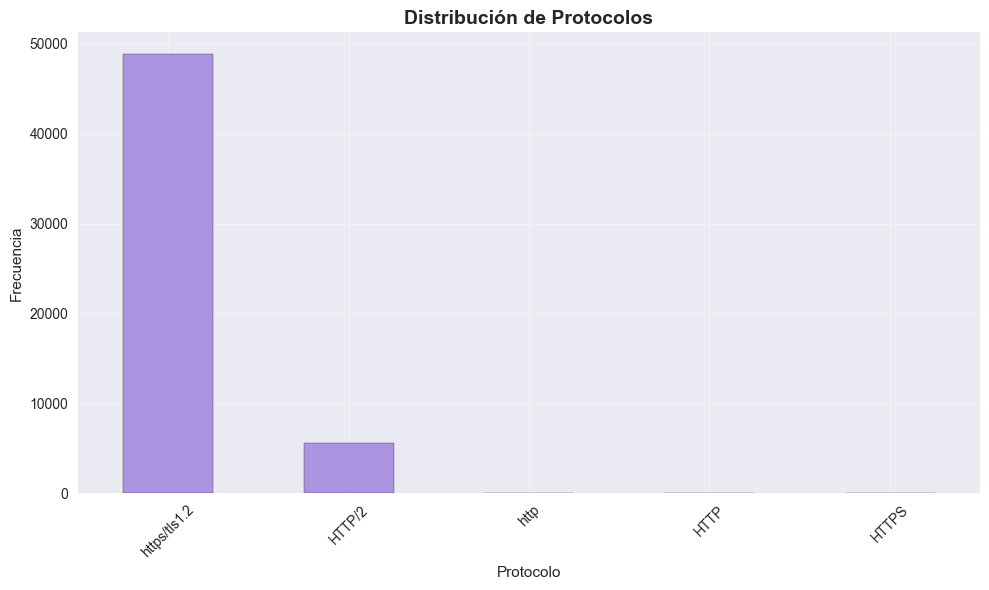

In [7]:
print("=== ANÁLISIS DE DIRECCIONES IP Y PROTOCOLOS ===")

# Análisis de IPs
ip_analysis = pd.DataFrame({
    'Metrica': [
        'Direcciones IP origen únicas',
        'Direcciones IP destino únicas',
        'Protocolos únicos'
    ],
    'Valor': [
        df['src_ip'].nunique(),
        df['dst_ip'].nunique(),
        df['protocol'].nunique() if 'protocol' in df.columns else 'N/A'
    ]
})
print(ip_analysis)

# Top direcciones IP
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top IPs origen
top_src_ips = df['src_ip'].value_counts().head(10)
ax1.barh(range(len(top_src_ips)), top_src_ips.values, color='lightblue', edgecolor='black')
ax1.set_yticks(range(len(top_src_ips)))
ax1.set_yticklabels(top_src_ips.index)
ax1.set_title('Top 10 Direcciones IP Origen', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frecuencia')
ax1.invert_yaxis()

# Top IPs destino
top_dst_ips = df['dst_ip'].value_counts().head(10)
ax2.barh(range(len(top_dst_ips)), top_dst_ips.values, color='lightcoral', edgecolor='black')
ax2.set_yticks(range(len(top_dst_ips)))
ax2.set_yticklabels(top_dst_ips.index)
ax2.set_title('Top 10 Direcciones IP Destino', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frecuencia')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Distribución de protocolos
if 'protocol' in df.columns:
    print("\nTop 10 Protocolos:")
    protocol_dist = df['protocol'].value_counts().head(10)
    print(protocol_dist)
    
    plt.figure(figsize=(10, 6))
    protocol_dist.plot(kind='bar', color='mediumpurple', edgecolor='black', alpha=0.7)
    plt.title('Distribución de Protocolos', fontsize=14, fontweight='bold')
    plt.xlabel('Protocolo')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

=== ANÁLISIS DE FUENTES DE LOGS ===


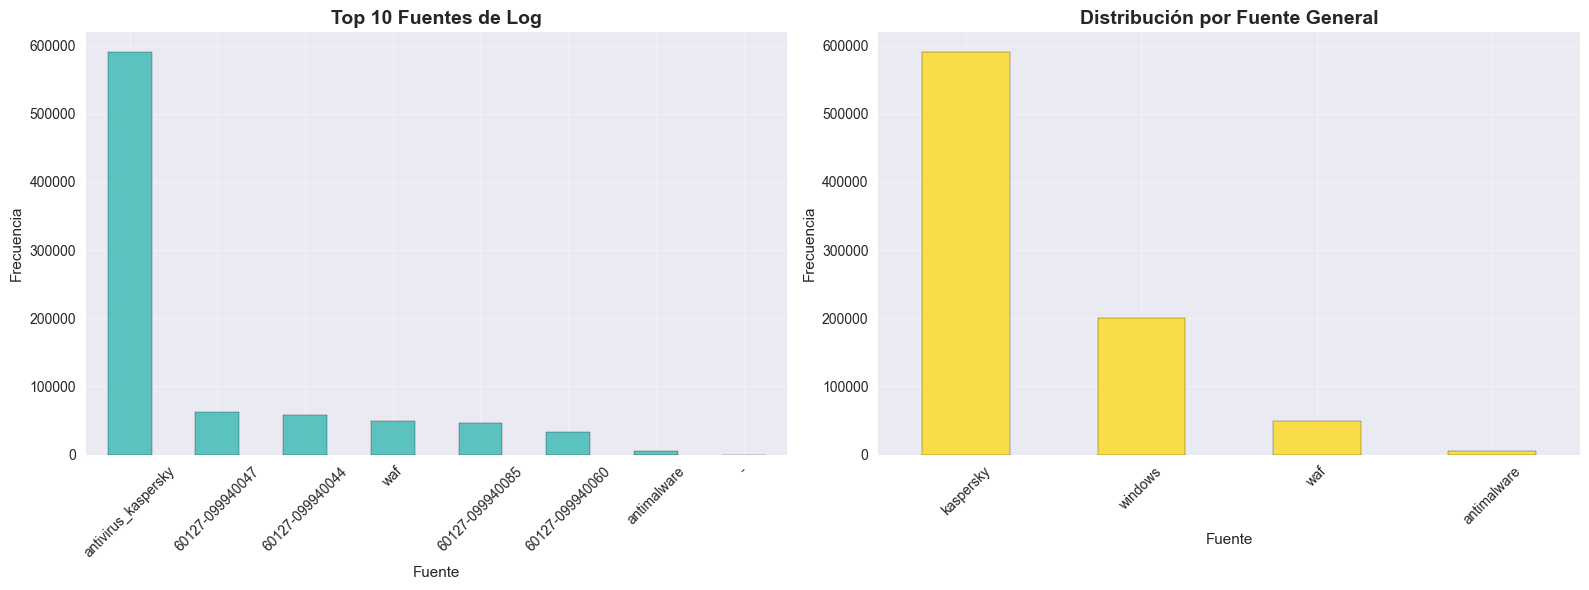

• Número de fuentes de log únicas: 8
• Fuente más común: antivirus_kaspersky (589,884 logs)


In [8]:
print("=== ANÁLISIS DE FUENTES DE LOGS ===")

if 'log_source' in df.columns and 'fuente' in df.columns:
    log_source_dist = df['log_source'].value_counts()
    fuente_dist = df['fuente'].value_counts()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Fuentes de log
    log_source_dist.head(10).plot(kind='bar', ax=ax1, color='lightseagreen', 
                                 edgecolor='black', alpha=0.7)
    ax1.set_title('Top 10 Fuentes de Log', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Fuente')
    ax1.set_ylabel('Frecuencia')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Distribución por fuente general
    fuente_dist.plot(kind='bar', ax=ax2, color='gold', 
                    edgecolor='black', alpha=0.7)
    ax2.set_title('Distribución por Fuente General', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Fuente')
    ax2.set_ylabel('Frecuencia')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"• Número de fuentes de log únicas: {df['log_source'].nunique()}")
    print(f"• Fuente más común: {log_source_dist.index[0]} ({log_source_dist.iloc[0]:,} logs)")

In [9]:
print("=== IDENTIFICACIÓN DE RIESGOS ===")

# 1. Desbalance de clases
print("\n1. DESBALANCE DE CLASES:")
target_balance = df[TARGET].value_counts(normalize=True)
max_class = target_balance.max()
min_class = target_balance.min()
imbalance_ratio = max_class / min_class

print(f"   • Clase mayoritaria: {target_balance.idxmax()} ({max_class:.2%})")
print(f"   • Clase minoritaria: {target_balance.idxmin()} ({min_class:.2%})")
print(f"   • Ratio de desbalance: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 10:
    print("ALTO DESBALANCE DETECTADO - Puede afectar severamente el rendimiento del modelo")
elif imbalance_ratio > 5:
    print("DESBALANCE MODERADO - Se recomiendan técnicas de balanceo")
else:
    print("Balance de clases aceptable")

# 2. Data Leakage potencial
print("\n2. RIESGO DE DATA LEAKAGE:")
time_based_leakage = df[TIME_COL].is_monotonic_increasing
if time_based_leakage:
    print("Los datos están ordenados temporalmente - menor riesgo de leakage temporal")
else:
    print("Los datos NO están ordenados temporalmente - riesgo de leakage")

if duplicate_count > 0:
    print(f"{duplicate_percentage:.2f}% de duplicados - riesgo de sobreajuste")

# 3. Data Drift potencial
print("\n3. RIESGO DE DATA DRIFT:")
first_half = df[df[TIME_COL] < df[TIME_COL].median()]
second_half = df[df[TIME_COL] >= df[TIME_COL].median()]

action_first = first_half[TARGET].value_counts(normalize=True)
action_second = second_half[TARGET].value_counts(normalize=True)

drift_detected = False
print("   Cambios en distribución temporal:")
for action in action_first.index:
    diff = abs(action_first[action] - action_second.get(action, 0))
    change_symbol = "↑" if action_second.get(action, 0) > action_first[action] else "↓"
    if diff > 0.05:  # Umbral del 5% de cambio
        print(f"{action}: {action_first[action]:.2%} → {action_second.get(action, 0):.2%} ({change_symbol}{diff:.2%})")
        drift_detected = True
    else:
        print(f"{action}: {action_first[action]:.2%} → {action_second.get(action, 0):.2%} ({change_symbol}{diff:.2%})")

# 4. Calidad de datos
print("\n4. CALIDAD DE DATOS:")
if len(high_missing_cols) > 0:
    print("Columnas con más del 50% de valores nulos:")
    for col, pct in high_missing_cols.items():
        print(f"      - {col}: {pct:.2f}% nulos")
else:
    print(" No hay columnas con más del 50% de valores nulos")

# 5. Cardinalidad
print("\n5. CARDINALIDAD DE VARIABLES:")
high_cardinality = []
for col in df.select_dtypes(include=['object']).columns:
    unique_ratio = df[col].nunique() / len(df)
    if unique_ratio > 0.5:  # Más del 50% de valores únicos
        high_cardinality.append((col, df[col].nunique(), f"{unique_ratio:.2%}"))

if high_cardinality:
    print("Variables con alta cardinalidad:")
    for col, unique_count, ratio in high_cardinality:
        print(f"      - {col}: {unique_count:,} valores únicos ({ratio})")

=== IDENTIFICACIÓN DE RIESGOS ===

1. DESBALANCE DE CLASES:
   • Clase mayoritaria: - (64.75%)
   • Clase minoritaria: El estado del dispositivo '10220-097700102' ha cambiado a Crítico: La protección está desactivada; La aplicación de seguridad no se está ejecutando. (0.00%)
   • Ratio de desbalance: 547312.00:1
ALTO DESBALANCE DETECTADO - Puede afectar severamente el rendimiento del modelo

2. RIESGO DE DATA LEAKAGE:
Los datos NO están ordenados temporalmente - riesgo de leakage
15.09% de duplicados - riesgo de sobreajuste

3. RIESGO DE DATA DRIFT:
   Cambios en distribución temporal:
-: 91.14% → 38.35% (↓52.79%)
Análisis experto: 0.88% → 0.05% (↓0.83%)
Análisis automático: 0.21% → 0.04% (↓0.17%)
Expert analysis: 0.14% → 0.00% (↓0.14%)
El estado del dispositivo '10221-006630040' ha cambiado a Crítico: La protección está desactivada.: 0.10% → 0.00% (↓0.10%)
El estado del dispositivo '11232-037701904' ha cambiado a Crítico: Hace mucho tiempo que no se comprueba si hay actualizaciones de

In [10]:
print("="*70)
print("RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS")
print("="*70)

print(f"\n DATOS GENERALES:")
print(f"   • Total de registros: {df.shape[0]:,}")
print(f"   • Período analizado: {(df[TIME_COL].max() - df[TIME_COL].min()).days} días")
print(f"   • Variables disponibles: {df.shape[1]}")
print(f"   • Registros duplicados: {duplicate_percentage:.1f}%")

print(f"\n VARIABLE OBJETIVO ('{TARGET}'):")
for action, pct in action_percentage.items():
    print(f"   • {action}: {pct:.1f}%")

print(f"\n  RIESGOS PRINCIPALES IDENTIFICADOS:")
print(f"   • Desbalance de clases: {imbalance_ratio:.1f}:1 ({'ALTO' if imbalance_ratio > 10 else 'MODERADO' if imbalance_ratio > 5 else 'BAJO'})")
print(f"   • Calidad de datos: {len(high_missing_cols)} columnas con >50% nulos")
print(f"   • Data drift: {'DETECTADO' if drift_detected else 'No detectado'}")

print(f"\n RECOMENDACIONES PARA MODELADO:")

if imbalance_ratio > 5:
    print("   1. Implementar técnicas de balanceo:")
    print("      - Oversampling (SMOTE, ADASYN)")
    print("      - Undersampling estratégico")
    print("      - Uso de pesos de clase en el modelo")

if len(high_missing_cols) > 0:
    print("   2. Manejo de valores nulos:")
    print("      - Eliminar columnas con >80% nulos")
    print("      - Imputar valores en columnas importantes")
    print("      - Crear indicadores de missingness")

if duplicate_count > 1000:
    print("   3. Limpieza de datos:")
    print("      - Eliminar duplicados exactos")
    print("      - Investigar causas de duplicación")

print("   4. Preprocesamiento:")
print("      - Codificación de variables categóricas")
print("      - Escalado de características numéricas")
print("      - Feature engineering temporal")

print("   5. Validación:")
print("      - Split temporal para evitar data leakage")
print("      - Cross-validation estratificado")
print("      - Monitoreo continuo de data drift")

print(f"\n PRÓXIMOS PASOS SUGERIDOS:")
print("   1. Limpieza y preprocesamiento de datos")
print("   2. Ingeniería de características")
print("   3. Modelado con técnicas para datos desbalanceados")
print("   4. Validación robusta del modelo")
print("   5. Implementación con monitoreo continuo")

print("\n" + "="*70)

RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS

 DATOS GENERALES:
   • Total de registros: 845,316
   • Período analizado: 456 días
   • Variables disponibles: 17
   • Registros duplicados: 15.1%

 VARIABLE OBJETIVO ('action'):
   • -: 64.7%
   • object-operation-performed: 8.8%
   • scheduled-task-updated: 4.4%
   • post: 3.6%
   • credential-manager-credentials-were-read: 2.7%
   • permissions-changed: 2.4%
   • get: 2.0%
   • created-process: 1.9%
   • exited-process: 1.9%
   • malware: 0.7%
   • Análisis experto: 0.5%
   • logged-in: 0.4%
   • user-member-enumerated: 0.2%
   • options: 0.2%
   • Análisis automático: 0.1%
   • logged-out: 0.1%
   • Ciclo de vida del proveedor: 0.1%
   • Expert analysis: 0.1%
   • Ninguna: 0.1%
   • El estado del dispositivo '10221-006630040' ha cambiado a Crítico: La protección está desactivada.: 0.0%
   • El estado del dispositivo '11232-092907509' ha cambiado a Crítico: No se ha realizado ningún análisis antimalware desde hace mucho tiempo; La